In [1]:
import tensorflow as tf
import pandas as pd
import seaborn as sns
import numpy as np
from tensorflow.keras import layers
from tensorflow.keras.layers import Normalization, Dense, InputLayer
from tensorflow.keras.losses import MeanSquaredError, Huber, MeanAbsoluteError
from tensorflow.keras.metrics import RootMeanSquaredError, Accuracy
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

#### Data Preparation

In [2]:
data = pd.read_csv("secondHandCarDataSet.csv")
data.head()
data.shape

(1000, 12)

In [3]:
tensor_data = tf.constant(data)
print(tensor_data)

tf.Tensor(
[[1.000000e+00 5.356510e+05 7.981860e+05 ... 7.300000e+01 1.230000e+02
  3.513180e+05]
 [2.000000e+00 5.919110e+05 8.610560e+05 ... 7.400000e+01 9.500000e+01
  2.850015e+05]
 [3.000000e+00 6.869900e+05 7.707620e+05 ... 5.300000e+01 9.700000e+01
  2.153860e+05]
 ...
 [9.980000e+02 6.463440e+05 8.427330e+05 ... 1.130000e+02 8.900000e+01
  4.058710e+05]
 [9.990000e+02 5.355590e+05 7.324390e+05 ... 1.120000e+02 1.280000e+02
  7.439800e+04]
 [1.000000e+03 5.901050e+05 7.797430e+05 ... 9.900000e+01 9.600000e+01
  4.149385e+05]], shape=(1000, 12), dtype=float64)


In [4]:
tensor_data = tf.random.shuffle(tensor_data)
print(tensor_data[:5])

tf.Tensor(
[[3.740000e+02 5.134850e+05 7.306280e+05 4.000000e+00 1.402960e+05
  4.000000e+00 5.000000e+00 1.500000e+01 2.000000e+02 9.400000e+01
  8.500000e+01 6.273700e+04]
 [7.800000e+01 5.746910e+05 7.515130e+05 2.000000e+00 1.147020e+05
  4.000000e+00 5.000000e+00 1.100000e+01 1.750000e+02 6.100000e+01
  1.200000e+02 2.065910e+05]
 [3.590000e+02 5.681500e+05 7.631960e+05 3.000000e+00 9.241200e+04
  4.000000e+00 9.000000e+00 1.100000e+01 1.380000e+02 5.400000e+01
  1.300000e+02 3.261615e+05]
 [9.000000e+02 6.959720e+05 7.092090e+05 4.000000e+00 1.209700e+05
  1.000000e+00 4.000000e+00 1.300000e+01 1.510000e+02 1.180000e+02
  1.070000e+02 2.189835e+05]
 [8.560000e+02 5.631320e+05 8.055850e+05 2.000000e+00 1.489570e+05
  3.000000e+00 9.000000e+00 8.000000e+00 1.390000e+02 8.800000e+01
  8.500000e+01 1.183485e+05]], shape=(5, 12), dtype=float64)


In [5]:
X = tensor_data[:, 3:-1]
X.shape, X[:5]

(TensorShape([1000, 8]),
 <tf.Tensor: shape=(5, 8), dtype=float64, numpy=
 array([[4.00000e+00, 1.40296e+05, 4.00000e+00, 5.00000e+00, 1.50000e+01,
         2.00000e+02, 9.40000e+01, 8.50000e+01],
        [2.00000e+00, 1.14702e+05, 4.00000e+00, 5.00000e+00, 1.10000e+01,
         1.75000e+02, 6.10000e+01, 1.20000e+02],
        [3.00000e+00, 9.24120e+04, 4.00000e+00, 9.00000e+00, 1.10000e+01,
         1.38000e+02, 5.40000e+01, 1.30000e+02],
        [4.00000e+00, 1.20970e+05, 1.00000e+00, 4.00000e+00, 1.30000e+01,
         1.51000e+02, 1.18000e+02, 1.07000e+02],
        [2.00000e+00, 1.48957e+05, 3.00000e+00, 9.00000e+00, 8.00000e+00,
         1.39000e+02, 8.80000e+01, 8.50000e+01]])>)

#### Vectorize the y axis

In [6]:
y = tensor_data[:,-1]
y = tf.expand_dims(y, axis = -1)
y[:5]

<tf.Tensor: shape=(5, 1), dtype=float64, numpy=
array([[ 62737. ],
       [206591. ],
       [326161.5],
       [218983.5],
       [118348.5]])>

In [7]:
TRAIN_RATIO = 0.8
VAL_RATIO = 0.1
TEST_RATIO = 0.1
DATASET_SIZE = len(X)

In [8]:
X_train = X[:int(DATASET_SIZE * TRAIN_RATIO)]
y_train = y[:int(DATASET_SIZE * TRAIN_RATIO)]
print(X_train.shape, y_train.shape)

(800, 8) (800, 1)


In [9]:
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
train_dataset = train_dataset.shuffle(buffer_size = 8, reshuffle_each_iteration = True).batch(32).prefetch(tf.data.AUTOTUNE)

In [10]:
X_val = X[int(DATASET_SIZE * TRAIN_RATIO):int(DATASET_SIZE*(TRAIN_RATIO + VAL_RATIO))]
y_val = y[int(DATASET_SIZE * TRAIN_RATIO):int(DATASET_SIZE*(TRAIN_RATIO + VAL_RATIO))]
print(X_val.shape, y_val.shape)

(100, 8) (100, 1)


In [11]:
val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val))
val_dataset = train_dataset.shuffle(buffer_size = 8, reshuffle_each_iteration = True).batch(32).prefetch(tf.data.AUTOTUNE)

In [12]:
X_test = X[int(DATASET_SIZE * VAL_RATIO):int(DATASET_SIZE*(VAL_RATIO + TEST_RATIO))]
y_test = y[int(DATASET_SIZE * VAL_RATIO):int(DATASET_SIZE*(VAL_RATIO + TEST_RATIO))]
print(X_test.shape, y_test.shape)

(100, 8) (100, 1)


In [13]:
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))
test_dataset = train_dataset.shuffle(buffer_size = 8, reshuffle_each_iteration = True).batch(32).prefetch(tf.data.AUTOTUNE)

#### Normalize the Data

In [14]:
normalizer = Normalization()
normalizer.adapt(X)
normalizer(X)[:5]

<tf.Tensor: shape=(5, 8), dtype=float32, numpy=
array([[-0.32650065,  1.373618  ,  0.72178036, -0.20970292,  1.5138369 ,
         1.7172813 ,  0.46102104, -0.87527764],
       [-1.4904962 ,  0.49518222,  0.72178036, -0.20970292, -0.28034067,
         0.4205157 , -1.1482109 ,  0.7875737 ],
       [-0.9084984 , -0.26985386,  0.72178036,  1.207211  , -0.28034067,
        -1.4986975 , -1.4895631 ,  1.2626741 ],
       [-0.32650065,  0.7103121 , -1.417883  , -0.5639314 ,  0.6167481 ,
        -0.8243793 ,  1.6313715 ,  0.16994321],
       [-1.4904962 ,  1.6708803 ,  0.00855922,  1.207211  , -1.6259738 ,
        -1.4468268 ,  0.16843343, -0.87527764]], dtype=float32)>

#### Build the Model

In [15]:
model = tf.keras.Sequential([normalizer,
                            Dense(128, activation = 'relu'),
                            Dense(128, activation = 'relu'),
                            Dense(128, activation = 'relu'),
                            Dense(1),
])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizatio  (None, 8)                17        
 n)                                                              
                                                                 
 dense (Dense)               (None, 128)               1152      
                                                                 
 dense_1 (Dense)             (None, 128)               16512     
                                                                 
 dense_2 (Dense)             (None, 128)               16512     
                                                                 
 dense_3 (Dense)             (None, 1)                 129       
                                                                 
Total params: 34,322
Trainable params: 34,305
Non-trainable params: 17
___________________________________________________

In [16]:
model.compile(optimizer = Adam(learning_rate = 0.1),
              loss = MeanAbsoluteError(),
             metrics= RootMeanSquaredError())

In [17]:
history = model.fit(train_dataset, validation_data=val_dataset, epochs = 350, verbose = 1)

Epoch 1/350
25/25 [==============================] - 1s 11ms/step - loss: 156084.7031 - root_mean_squared_error: 203952.7031 - val_loss: 57026.5391 - val_root_mean_squared_error: 70521.9844
Epoch 2/350
25/25 [==============================] - 0s 4ms/step - loss: 52697.9297 - root_mean_squared_error: 65235.9141 - val_loss: 41914.7266 - val_root_mean_squared_error: 52342.3164
Epoch 3/350
25/25 [==============================] - 0s 4ms/step - loss: 46939.5703 - root_mean_squared_error: 58875.9922 - val_loss: 49186.4219 - val_root_mean_squared_error: 60447.2734
Epoch 4/350
25/25 [==============================] - 0s 4ms/step - loss: 42989.1211 - root_mean_squared_error: 54293.3867 - val_loss: 38022.5352 - val_root_mean_squared_error: 47727.6758
Epoch 5/350
25/25 [==============================] - 0s 4ms/step - loss: 40484.2188 - root_mean_squared_error: 51876.4219 - val_loss: 39744.3633 - val_root_mean_squared_error: 51112.0156
Epoch 6/350
25/25 [==============================] - 0s 4ms/st

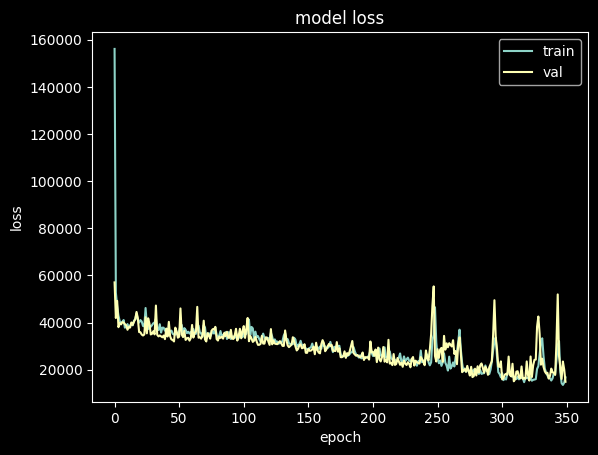

In [18]:
plt.style.use('dark_background')
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'])
plt.show()

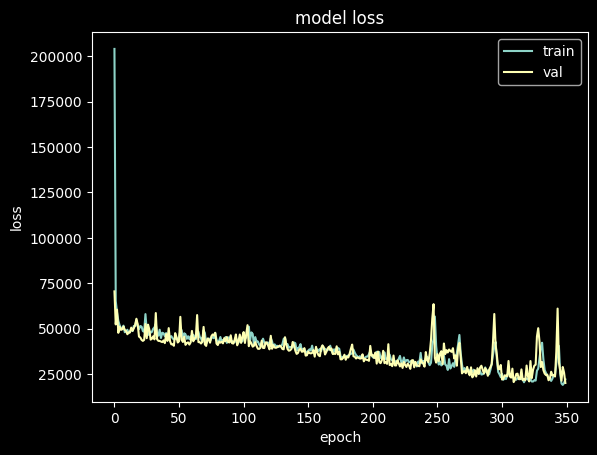

In [19]:
plt.style.use('dark_background')
plt.plot(history.history['root_mean_squared_error'])
plt.plot(history.history['val_root_mean_squared_error'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'])
plt.show()

In [20]:
model.evaluate(X_test, y_test)

4/4 [==============================] - 0s 3ms/step - loss: 18164.6934 - root_mean_squared_error: 23307.3516


[18164.693359375, 23307.3515625]

In [21]:
model.predict(tf.expand_dims(X_test[0], axis=0))

array([[68537.08]], dtype=float32)

In [22]:
y_true = list(y_test[:,0].numpy())
y_pred = list(model.predict(X_test)[:,0])
print(y_pred)

[68556.75, 365972.0, 253413.52, 176456.14, 138655.12, 490096.44, 335466.62, 244656.61, 98605.17, 251511.67, 146286.95, 279493.56, 343626.38, 400985.28, 181317.45, 299907.06, 433257.38, 239439.86, 330189.06, 425220.03, 188894.39, 350553.44, 131949.52, 476199.62, 436239.94, 253541.27, 115324.4, 183608.72, 146615.19, 166533.33, 400028.34, 243977.08, 414239.06, 126196.44, 177342.94, 308173.0, 550302.7, 410238.34, 361777.78, 450841.94, 151417.95, 503221.8, 468314.97, 213810.17, 468098.44, 321473.38, 401342.7, 149876.92, 468690.12, 61910.77, 345504.84, 193788.22, 341158.28, 417128.2, 505495.44, 330986.44, 340147.4, 303037.84, 589607.56, 393186.94, 98031.63, 170588.16, 549093.6, 540112.56, 300041.7, 430557.2, 565921.94, 452752.3, 164837.17, 298274.9, 384432.06, 195979.61, 546448.1, 262195.44, 500762.2, 184311.67, 233622.42, 327587.94, 306013.5, 357984.7, 308329.94, 237510.33, 444163.53, 84036.984, 357824.5, 444660.06, 275833.72, 244488.36, 409246.6, 396715.06, 461478.38, 435580.4, 108496.79, 

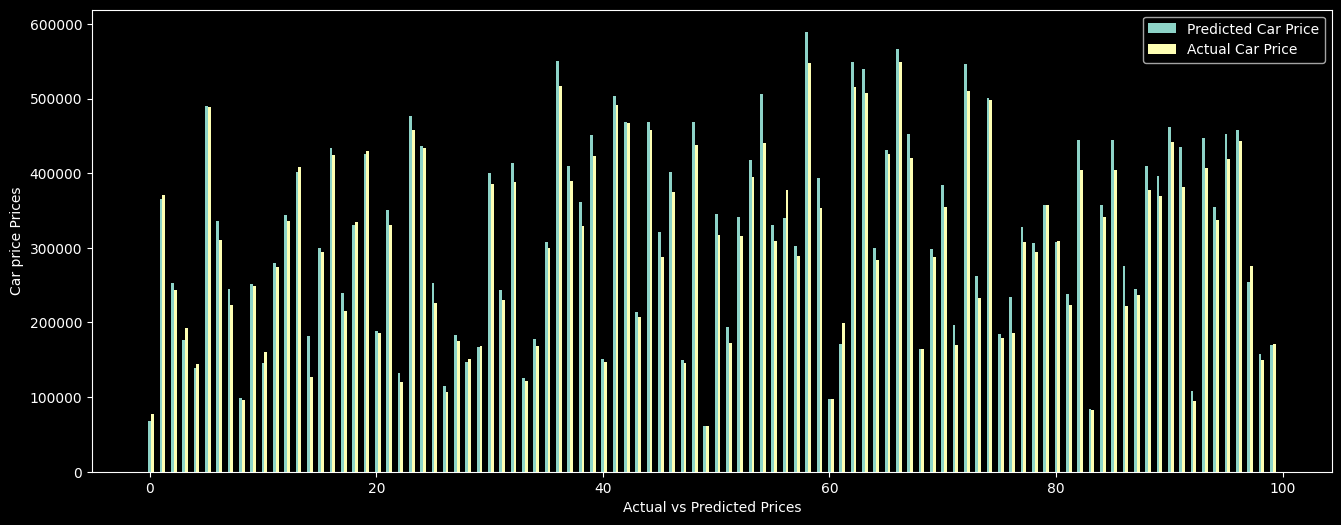

In [23]:
ind = np.arange(100)
plt.figure(figsize=(16,6))

width = 0.25

plt.bar(ind, y_pred, width, label='Predicted Car Prize')
plt.bar(ind + width, y_true, width, label='Actual Car Prize')

plt.legend(['Predicted Car Price','Actual Car Price', ])

plt.xlabel('Actual vs Predicted Prices')
plt.ylabel('Car price Prices')
plt.show()